In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt



In [19]:
# Cargar el dataset desde el archivo CSV
path = "dataset/divvy_daily.csv"
df = pd.read_csv(path)

In [20]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.set_index('date')
lstm_df = df.drop(columns = ['temperature', 'weather'])

In [21]:
lstm_df

,rides
date,
2014-01-01,95
2014-01-02,111
2014-01-03,6
2014-01-04,181
2014-01-05,32
...,...
2017-12-27,1117
2017-12-28,1267
2017-12-29,1049


In [22]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(lstm_df) * 0.8)
test_size = len(lstm_df) - train_size
train_data, test_data = lstm_df.iloc[0:train_size], lstm_df.iloc[train_size:len(lstm_df)]


In [23]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [24]:
# Crear el conjunto de datos para entrenamiento
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [25]:
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)


In [26]:
# Reshape de los datos para [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [27]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/home/juanperdomo/forecasting-divvy-bike-rides/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1323
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0192
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0195
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0184
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0188
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0193
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0202
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0188
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0178
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0187
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0175
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0194
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0181
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0204
Epoch 15/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

In [29]:
# Invertir la escala de las predicciones
train_predict = scaler.inverse_transform(train_predict)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

In [30]:
# Calcular MAPE para el conjunto de prueba
mape = mean_absolute_percentage_error(y_test_true, test_predict)
print(f'MAPE: {mape:.4f}')

MAPE: 0.3212


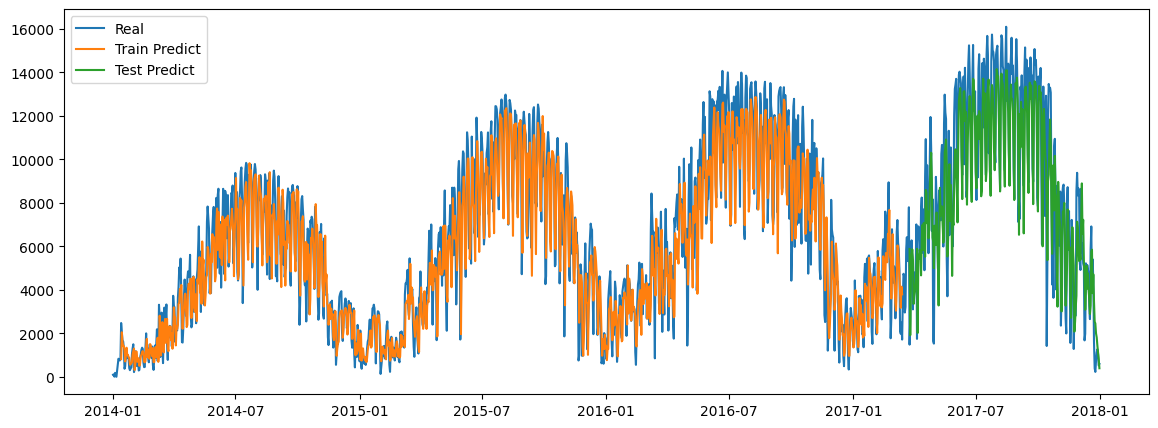

In [31]:
# Visualizar los resultados
plt.figure(figsize=(14, 5))

# Ajustar los índices para los valores reales y las predicciones
train_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2):len(lstm_df), :] = test_predict

plt.plot(lstm_df.index, scaler.inverse_transform(np.concatenate((train_scaled, test_scaled), axis=0)), label='Real')
plt.plot(lstm_df.index, train_predict_plot, label='Train Predict')
plt.plot(lstm_df.index, test_predict_plot, label='Test Predict')
plt.legend()
plt.show()

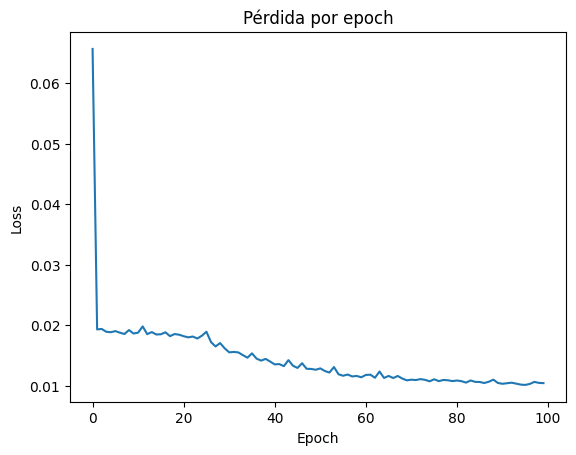

In [32]:
loss_per_epoch = history.history['loss']

plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida por epoch')
plt.show()